## Simulate data

In [3]:
#How many runs per set of parameters. In paper N=50
N = 1
!seq 1 $N > Simulation/sim.txt
!echo "0.3\n0.5\n0.7" > Simulation/h2s.txt
!echo "1000\n3000\n10000" > Simulation/d.txt

In [12]:
!parallel -j 10 --bar -v -a Simulation/d.txt -a Simulation/h2s.txt -a Simulation/sim.txt bash Simulation/simulate.sh

Academic tradition requires you to cite works you base your article on.
When using programs that use GNU Parallel to process data for publication
please cite:

  O. Tange (2011): GNU Parallel - The Command-Line Power Tool,
  ;login: The USENIX Magazine, February 2011:42-47.

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

To silence this citation notice: run 'parallel --citation'.

0% 0:9=0s 10000 0.7 1                                                           bash Simulation/simulate.sh 1000 0.3 1
11% 1:8=0s 10000 0.7 1                                                          bash Simulation/simulate.sh 1000 0.5 1
22% 2:7=0s 10000 0.7 1                                                          bash Simulation/simulate.sh 1000 0.7 1
33% 3:6=0s 10000 0.7 1                                                          bash Simulation/simulate.sh 3000 0.3 1
44% 4:5=0s 10000 0.7 1                

## Train lassonet and p thresholding

In [15]:
!parallel -v -j 4 --bar -a Simulation/sim.txt -a Simulation/method.txt -a Simulation/h2s.txt -a Simulation/d.txt python train.py

Academic tradition requires you to cite works you base your article on.
When using programs that use GNU Parallel to process data for publication
please cite:

  O. Tange (2011): GNU Parallel - The Command-Line Power Tool,
  ;login: The USENIX Magazine, February 2011:42-47.

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

To silence this citation notice: run 'parallel --citation'.

0% 0:18=0s 1 p 0.5 1000                                                         python train.py 1 p 0.5 1000
Namespace(d=1000, h2s=0.5, i=1, method='p')
Figure(1000x1000)
100%|██████████| 4/4 [00:04<00:00,  1.09s/it]
5% 1:17=18s 1 p 0.5 3000                                                        python train.py 1 p 0.3 1000
Namespace(d=1000, h2s=0.3, i=1, method='p')
Figure(1000x1000)
100%|██████████| 4/4 [00:04<00:00,  1.12s/it]
11% 2:16=97s 1 p 0.5 10000                                                      

## Generate plots

In [17]:
#this is not the same data trained above
#first combine all the data into one file
!cat /home/shussain/FADS/Conf/n600/results/d_*/h2s_*/sim_*/n_causals1.csv > n600.csv

In [21]:
import pandas as pd

n600 = pd.read_csv("/home/shussain/FADS/Conf/n600.csv", names=["h2s", "i", "k", "method", "n_causals", "svm", "lr", "d"])
n1200 = pd.read_csv("/home/shussain/FADS/Conf/n1200.csv", names=["h2s", "i", "k", "method", "n_causals", "svm", "lr", "d"])
n600

,h2s,i,k,method,n_causals,svm,lr,d
0,0.3,10,5,ln,2,0.618604,0.628615,10000
1,0.3,10,25,ln,3,0.558676,0.670745,10000
2,0.3,10,100,ln,3,0.652392,0.715795,10000
3,0.3,10,300,ln,5,0.687430,0.755562,10000
4,0.3,10,5,p,1,0.435206,0.632091,10000
...,...,...,...,...,...,...,...,...
3595,0.7,9,300,ln,6,0.870510,0.878864,3000
3596,0.7,9,5,p,1,0.442634,0.745614,3000
3597,0.7,9,25,p,1,0.457254,0.771234,3000
3598,0.7,9,100,p,4,0.738791,0.891674,3000


In [22]:
n1200

,h2s,i,k,method,n_causals,svm,lr,d
0,0.3,10,5,p,2,0.587311,0.686677,10000
1,0.3,10,25,p,3,0.505470,0.733886,10000
2,0.3,10,100,p,3,0.580865,0.716954,10000
3,0.3,10,300,p,6,0.685945,0.724409,10000
4,0.3,10,5,ln,2,0.541635,0.668595,10000
...,...,...,...,...,...,...,...,...
3595,0.7,9,300,ln,8,0.843403,0.897361,3000
3596,0.7,9,5,p,1,0.409583,0.741597,3000
3597,0.7,9,25,p,2,0.628542,0.802083,3000
3598,0.7,9,100,p,4,0.773542,0.867014,3000


In [46]:
import seaborn as sns
from itertools import product
from statannot import add_stat_annotation
def plot_criter(df, crit, d, legend=True, suptitle=""):
    fig, axes = plt.subplots(4, 3, figsize=(20, 20), squeeze=False, sharex=True, sharey=True)
    dff = df.query(f"d == {d}")
    
    if crit=="svm":
        plt.suptitle("Support Vector Machine")
        plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1])
    elif crit=="lr":
        plt.suptitle("Logistic regression")
        plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1])
    else:
        plt.suptitle(suptitle)
        
    plt.tight_layout()

    for (k, h2s), ax in zip(product([5, 25, 100, 300], [0.3, 0.5, 0.7]), axes.ravel()):
        plt.sca(ax)

        dfff = dff.query(f"k == {k} and h2s == {h2s}")
        sns.boxplot(x=dfff["method"], y=dfff[f"{crit}"], order=["p", "ln"])
        
        
        if k==5:
            plt.title(f"$h^2_s = {h2s}$")
        if h2s == 0.3:
            plt.ylabel(f"$k={k}$")
        else:
            plt.ylabel("")
        
        plt.xlabel("")
        plt.xticks([])
                  

        test_results = add_stat_annotation(
            ax, x=dfff["method"], y=dfff[f"{crit}"], 
            order=["p", "ln"],
            box_pairs=[
                ("p", "ln")
            ],
            test='Wilcoxon', text_format='star',
            loc='inside', verbose=0,
            pvalue_thresholds=[[1e-3, "***"], [1e-2, "**"], [0.05, "*"], [1, "ns"]]
        )
        #plt.title(f"$h^2_s$ = {h2s}, $k$ = {k}")


Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox


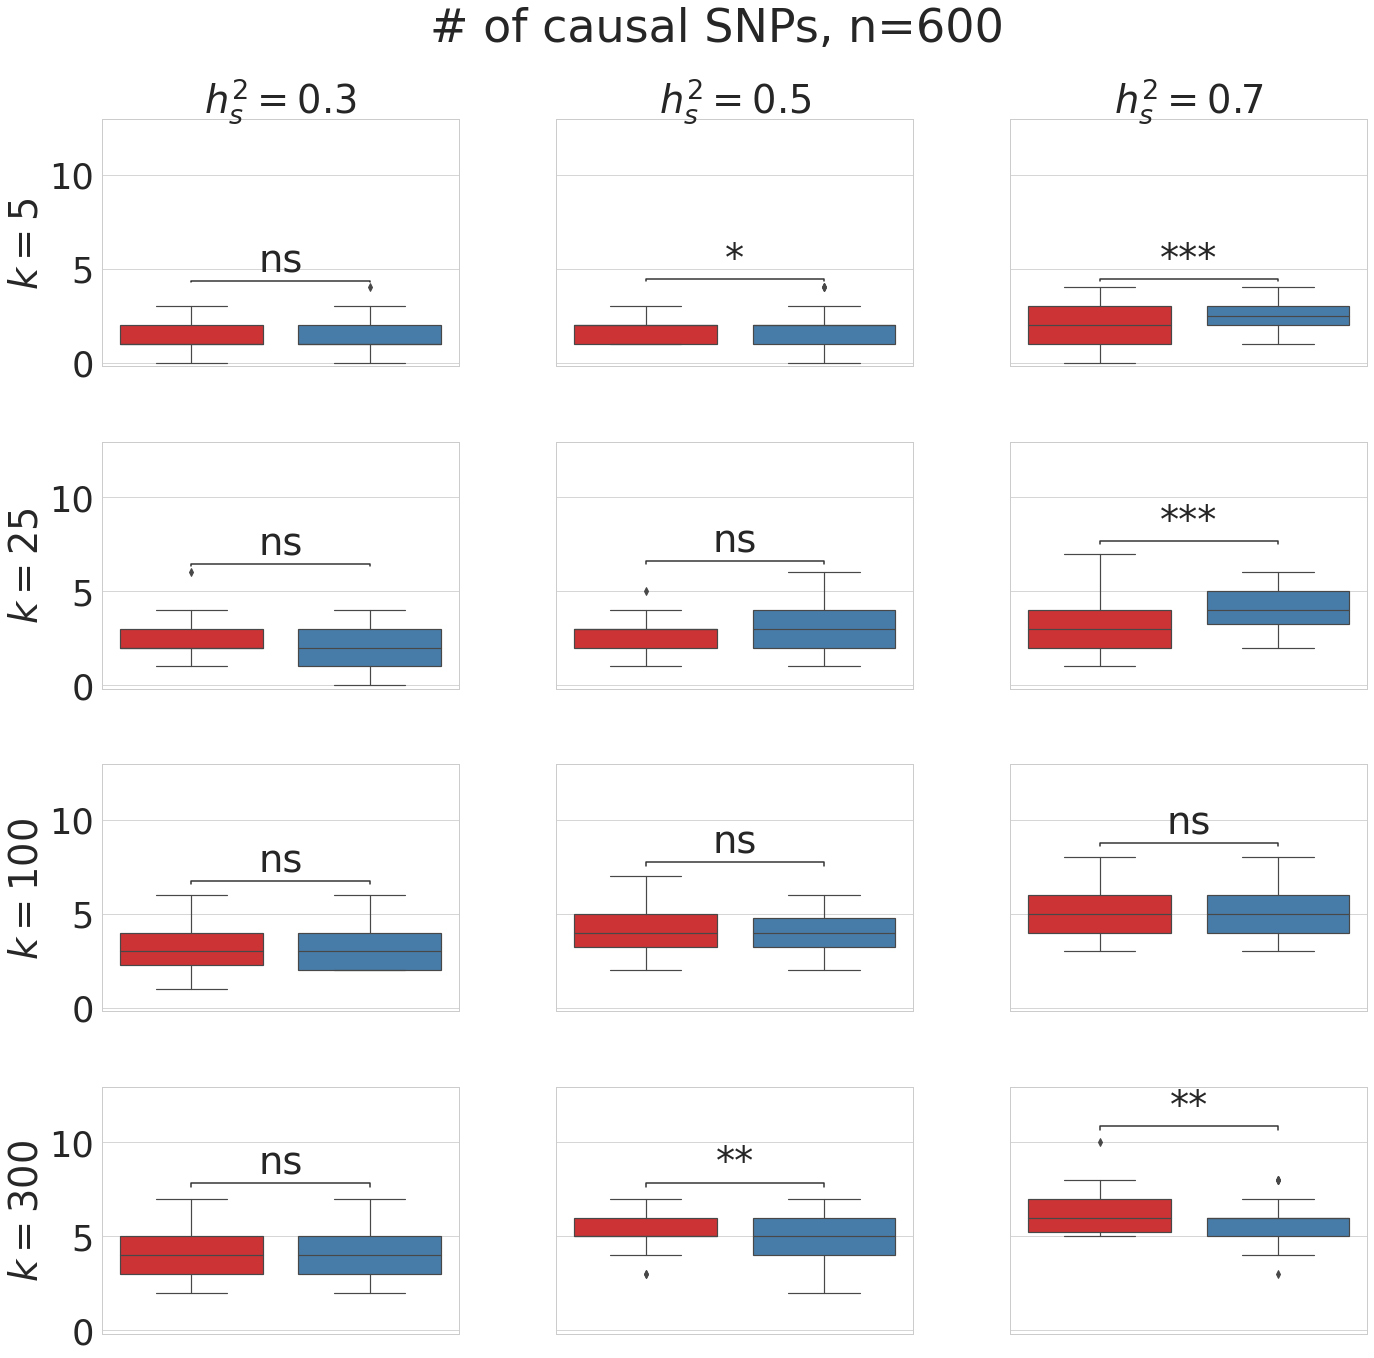

In [36]:
plot_criter(n600, "n_causals", "10000", legend=False, suptitle="# of causal SNPs, n=600")
plt.savefig("n_causals_10k_600.jpeg", bbox_inches='tight')

Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox


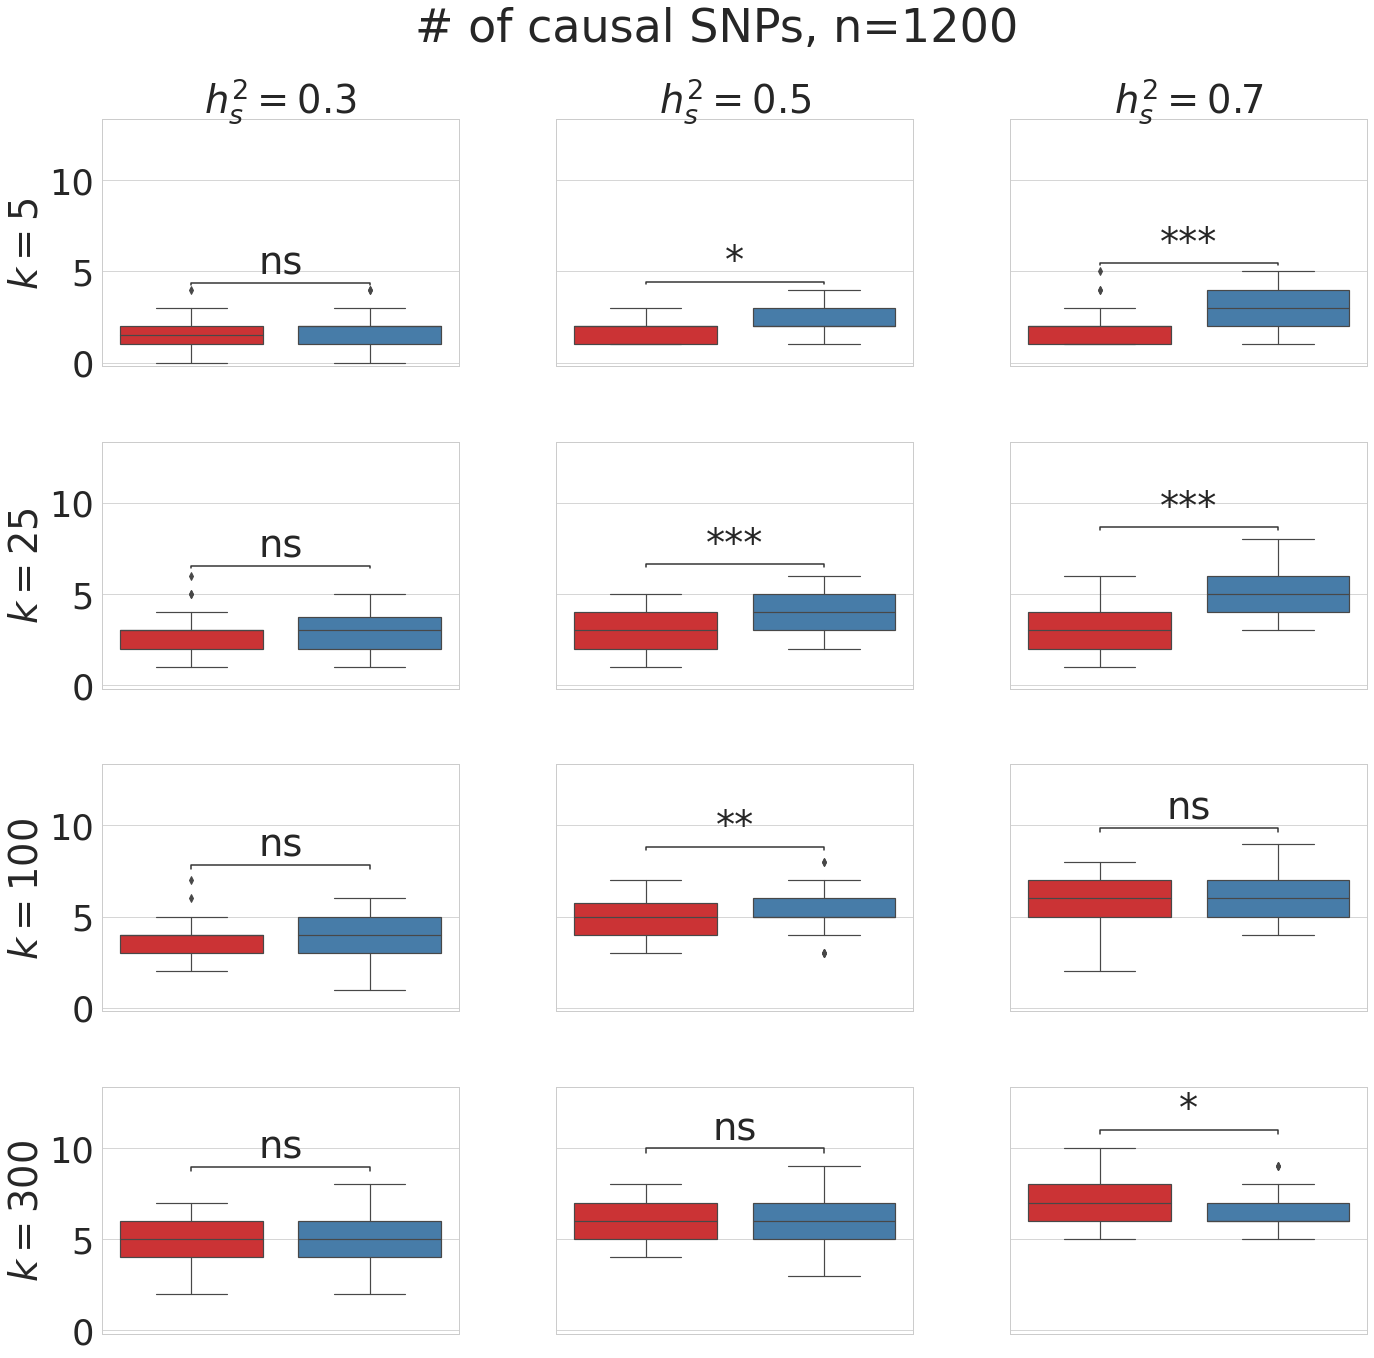

In [37]:
plot_criter(n1200, "n_causals", "10000", legend=False, suptitle="# of causal SNPs, n=1200")
plt.savefig("n_causals_10k_1200.jpeg", bbox_inches='tight')

Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox


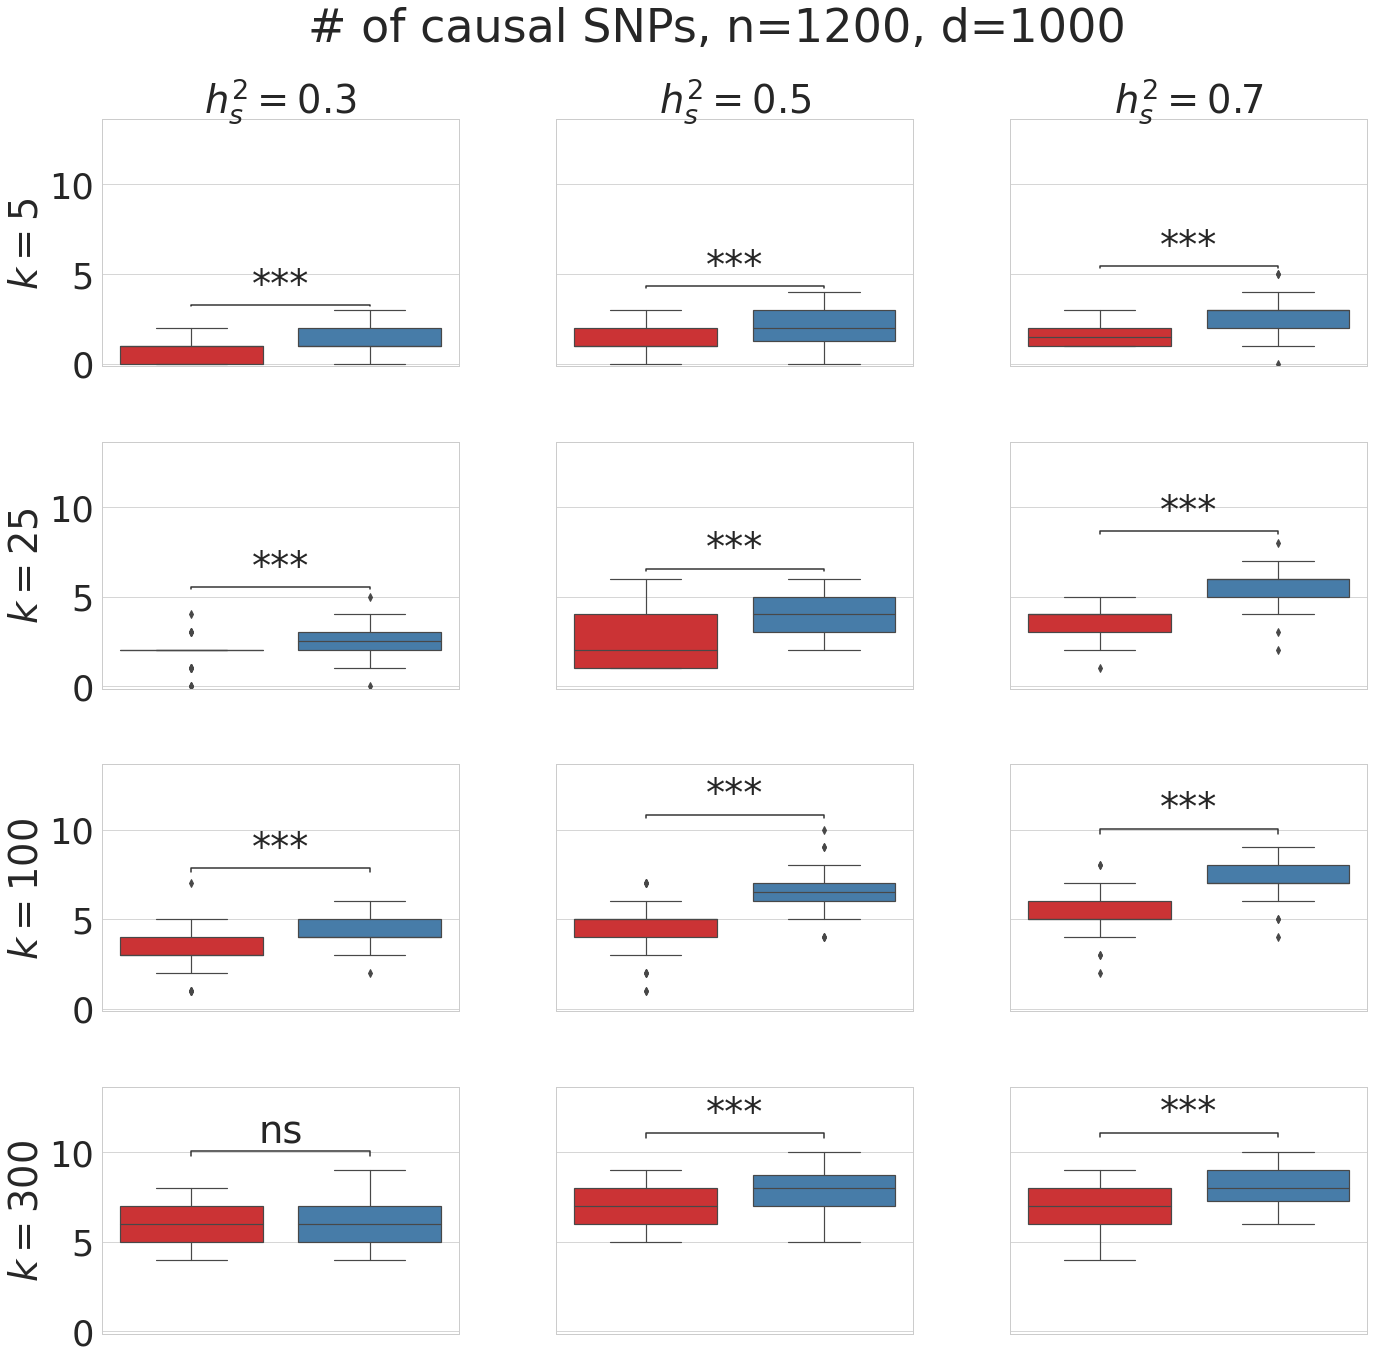

In [39]:
plot_criter(n1200, "n_causals", "1000", legend=False, suptitle="# of causal SNPs, n=1200, d=1000")
plt.savefig("n_causals_1k_1200.jpeg", bbox_inches='tight')

Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox


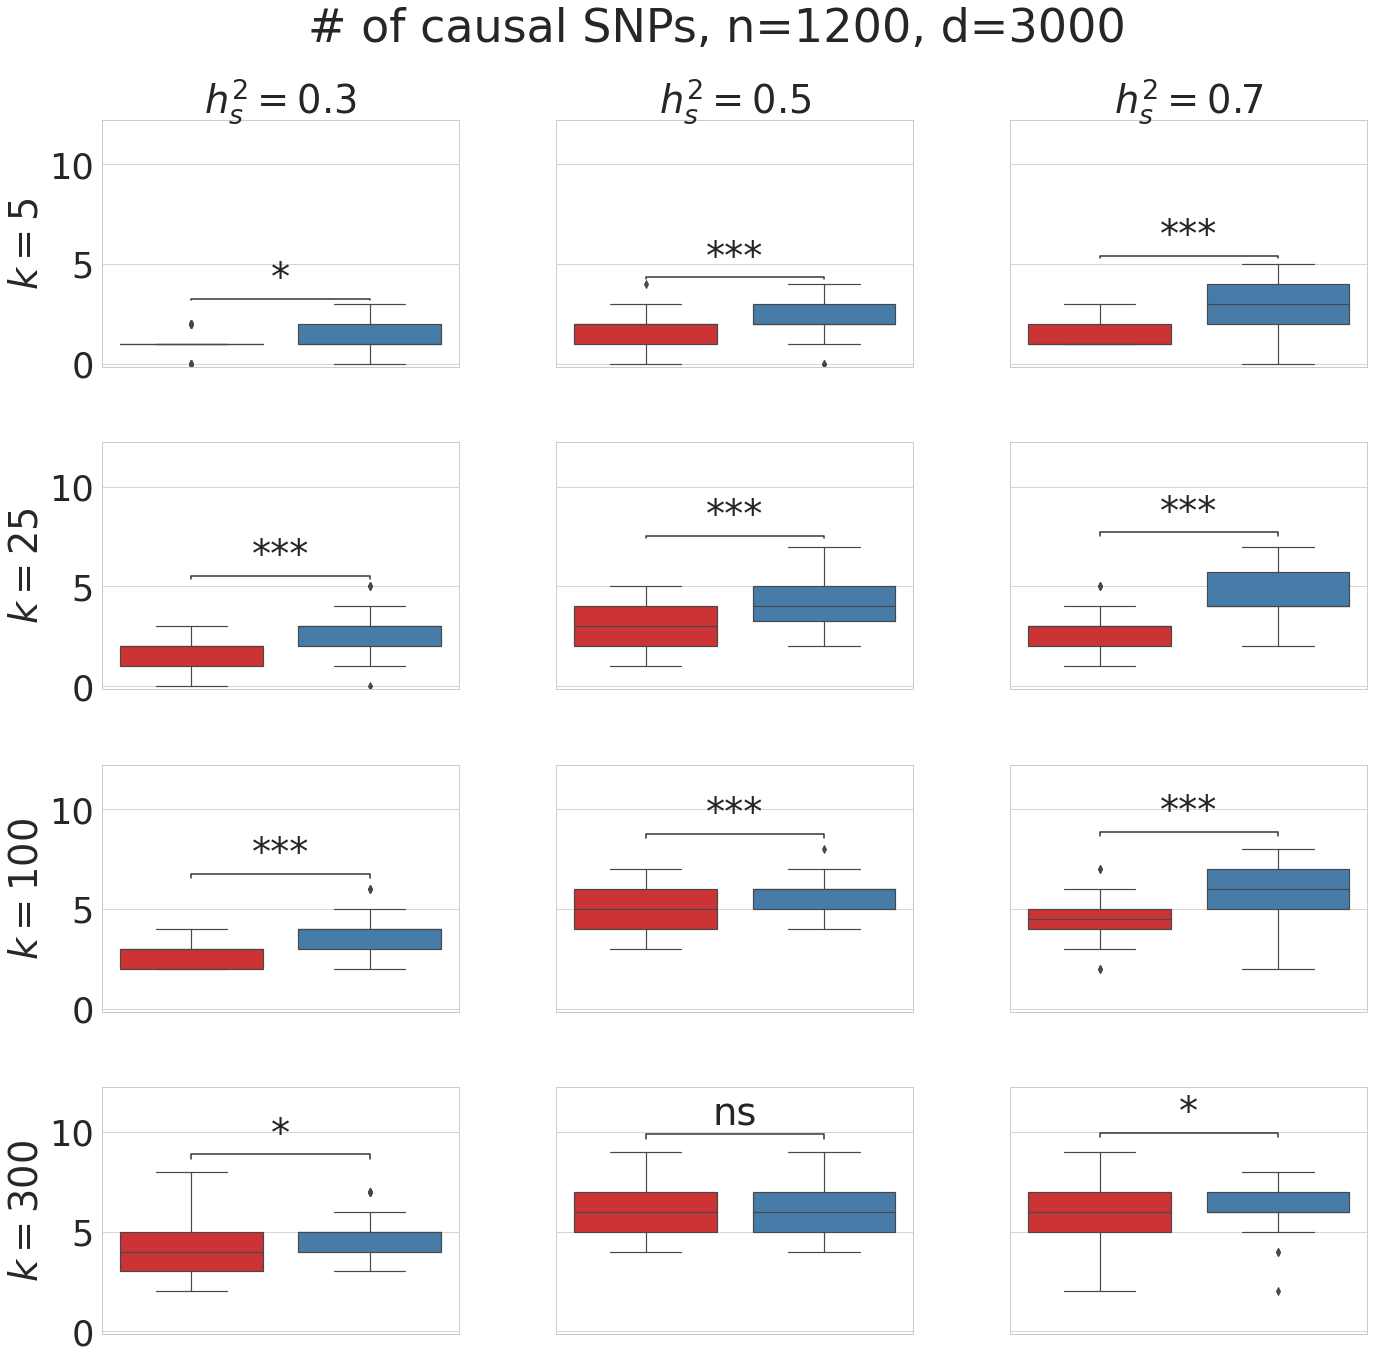

In [40]:
plot_criter(n1200, "n_causals", "3000", legend=False, suptitle="# of causal SNPs, n=1200, d=3000")
plt.savefig("n_causals_3k_1200.jpeg", bbox_inches='tight')

Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox


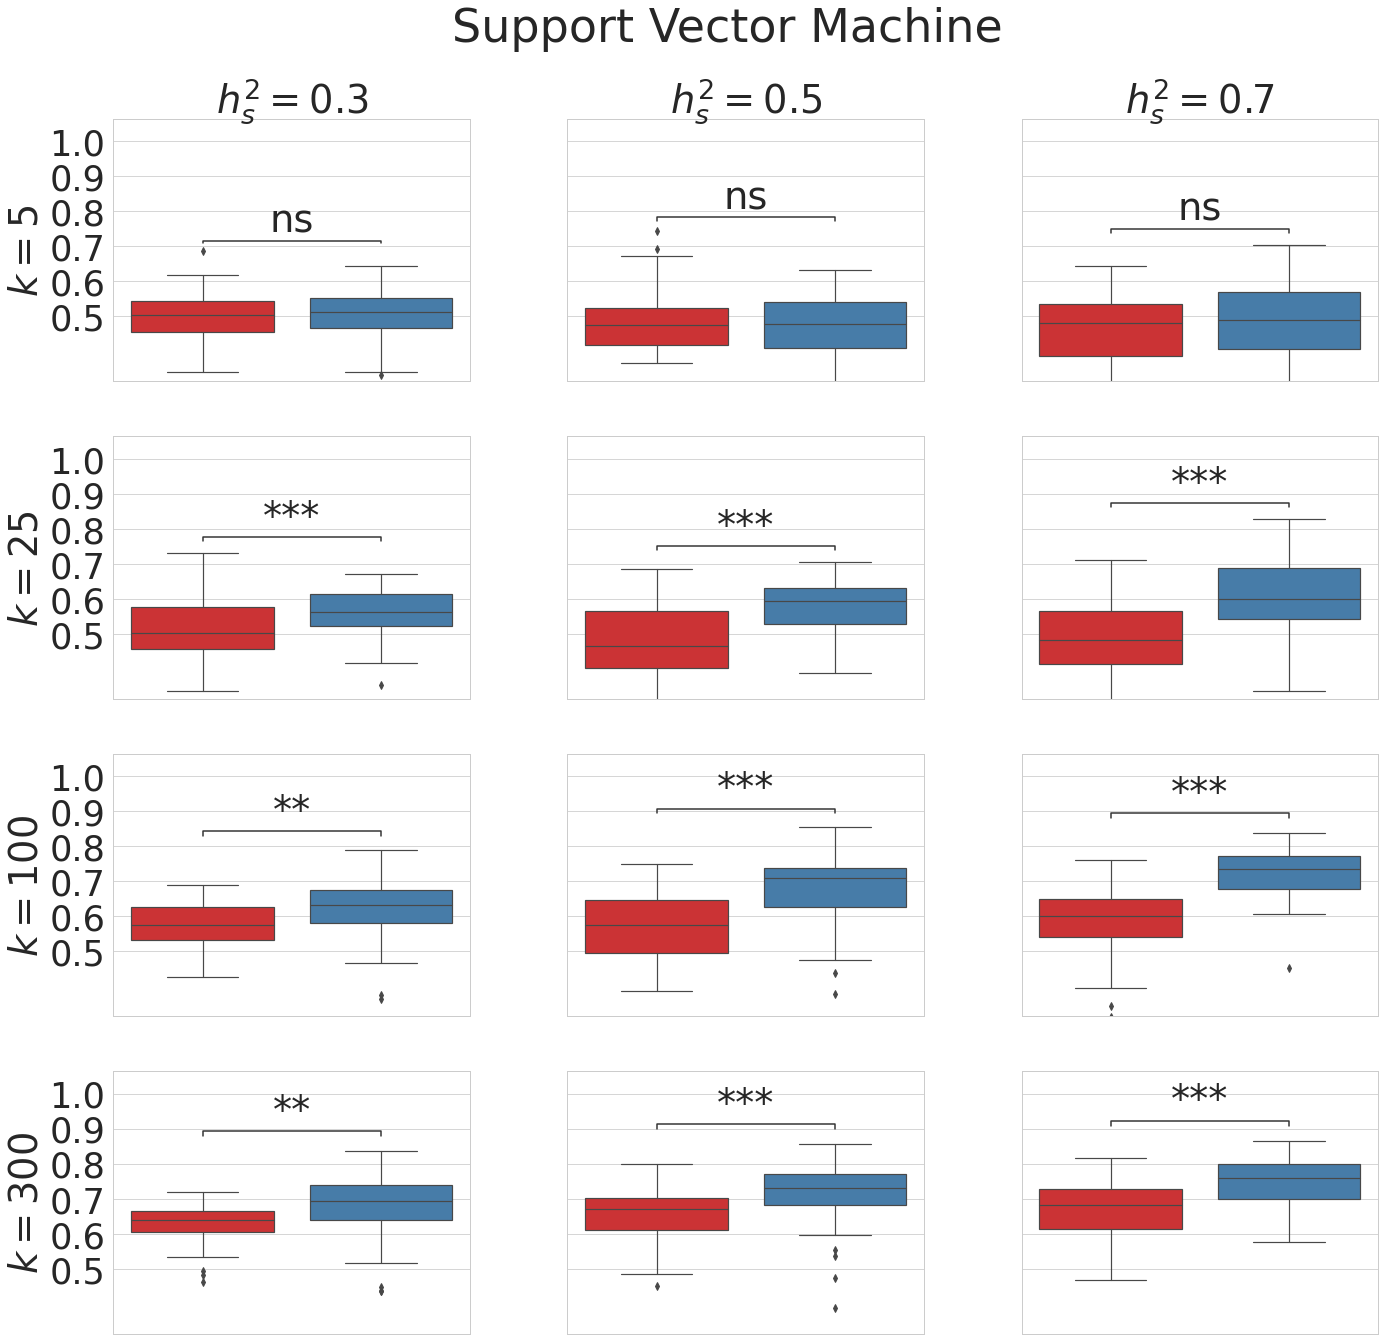

In [47]:
plot_criter(n1200, "svm", "10000", legend=False)
plt.savefig("svm_10k_1200.jpeg", bbox_inches='tight')

Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox
Using zero_method  wilcox


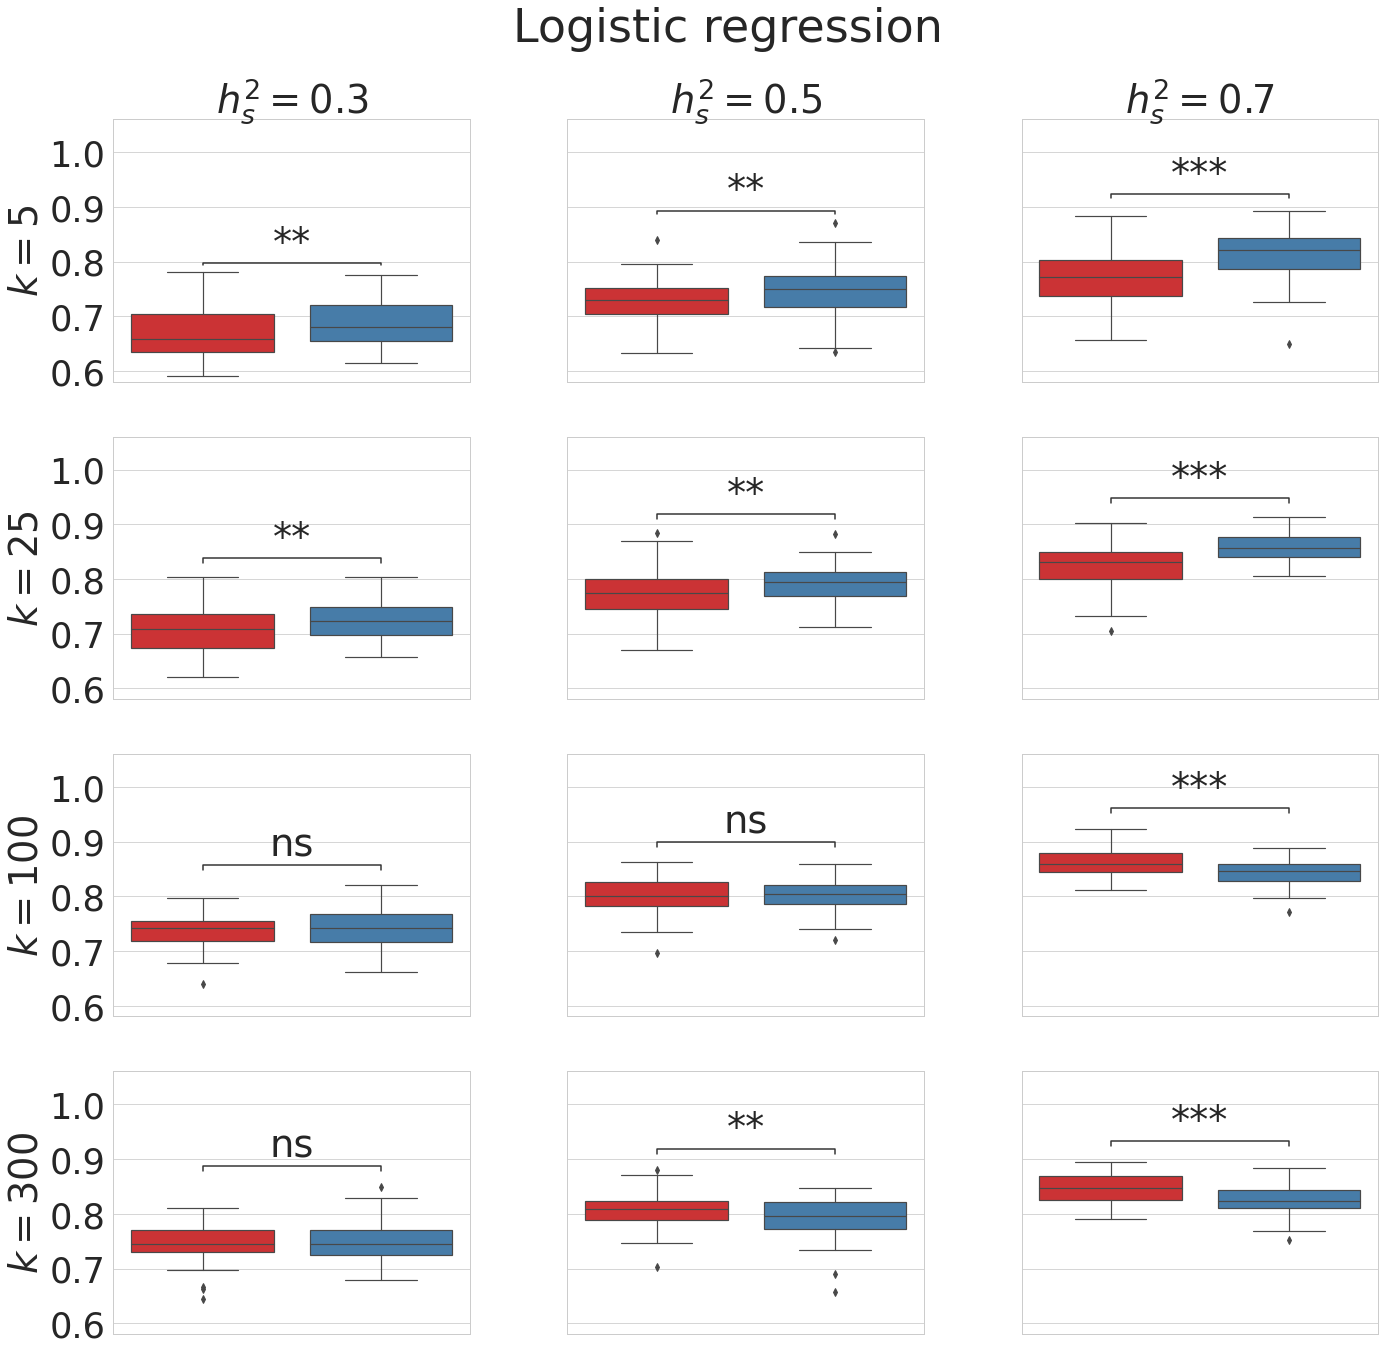

In [48]:
plot_criter(n1200, "lr", "10000", legend=False)
plt.savefig("lr_10k_1200.jpeg", bbox_inches='tight')

## Manhattan

In [1]:
from utils.input import get_dset
from utils.FeatureSelector import *
dset = get_dset("/home/shussain/Simulated_data/18082021/10000/0.5/sim_1/sim_1/PS/output/")

In [2]:
p = pValue(dset)
ln = LassoNet(dset, (1200, 800, 200,))

In [12]:
import seaborn as sns
sns.set_theme(
    context = 'paper',
    palette='Set1',
    style = 'whitegrid',
    font_scale = 4
)
cmap=sns.color_palette('Set1')
cmap

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6)]

In [13]:
self.importance

array([0.43032665, 1.37119046, 0.31531637, ..., 0.54380586, 5.99885793,
       0.3736756 ])

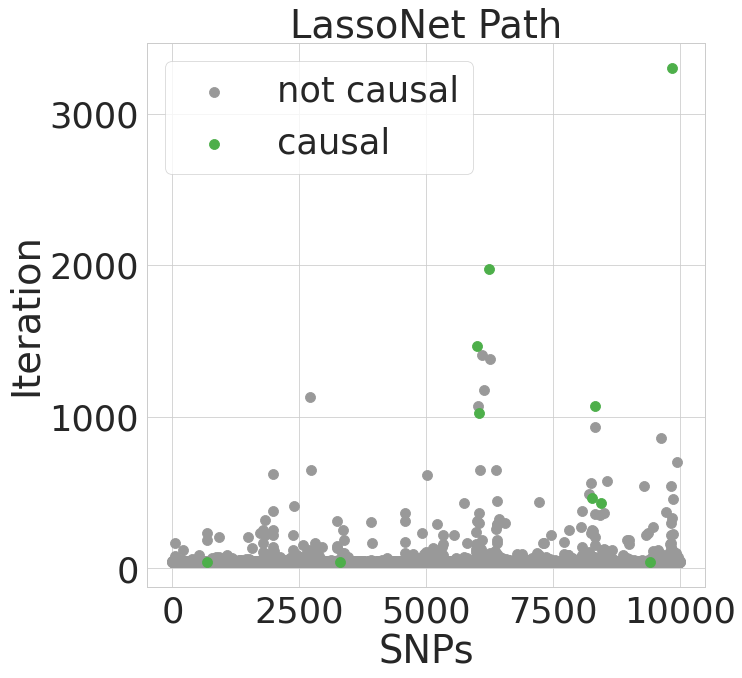

In [41]:
#code from FeatureSelector.py but modified for publication
self = ln
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
title = "P-thresholding" if isinstance(self, pValue) else "LassoNet Path" 

plt.title(title)
groups = self.dset["ct"].groupby("causal")
for i, (is_causal, group) in zip((8, 2), groups):
    plt.scatter(group.index.values, self.importance[group.index.values], label="causal" if is_causal else "not causal", color=cmap[i], s=100)
plt.legend()
plt.xlabel("SNPs")
plt.ylabel("Iteration")
plt.savefig("ln.jpeg")

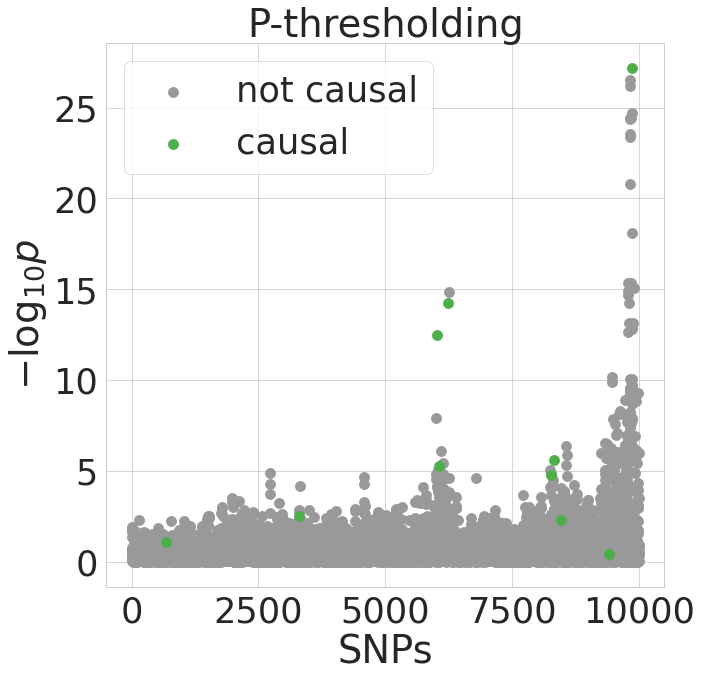

In [42]:
self = p
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
title = "P-thresholding" if isinstance(self, pValue) else "LassoNet Path" 

plt.title(title)
groups = self.dset["ct"].groupby("causal")
for i, (is_causal, group) in zip((8, 2), groups):
    plt.scatter(group.index.values, self.importance[group.index.values], label="causal" if is_causal else "not causal", color=cmap[i], s=100)
plt.legend()
plt.xlabel("SNPs")
plt.ylabel("$-\log_{10} p$")
plt.savefig("p.jpeg")